In this notebook, we discuss how the metapath2vec helps in learning the node embeddings of the hetergenous graph

In [74]:
# Visualize the classification results
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from model.utils import create_hetero_data,get_parser
from model.models import HeteroGNN_SMOTE
from torch.nn import functional as F

In [68]:
# Load the data
data_name = "amlsim_mixed"
ext_rates = np.arange(0.1, 1, 0.1)
ext_rates = np.array([np.round(x, 1) for x in ext_rates])
ext_rate  = 0.1
data_path = f'hetero_data/{data_name}/ext_{ext_rate}/'
data = create_hetero_data(data_path)
model_name = "SAGE"
smote_model_dict = torch.load(f'model_pths/{data_name}/baseline_hetero_{model_name}-SMOTE-Featb_ext_{ext_rate}.pth')
featb_model_dict = torch.load(f'model_pths/{data_name}/baseline_hetero_{model_name}-SMOTE_ext_{ext_rate}.pth')    

In [69]:
smote_model = HeteroGNN_SMOTE(hidden_channels=64, out_channels=2,
                  num_layers=2,model_name='SAGE',
                  meta_data=data.metadata())

featb_model = HeteroGNN_SMOTE(hidden_channels=64, out_channels=2,
                  num_layers=2,model_name='SAGE',
                  meta_data=data.metadata())

smote_model.load_state_dict(smote_model_dict)
featb_model.load_state_dict(featb_model_dict)

<All keys matched successfully>

In [70]:
x_dict, edge_index_dict = data.x_dict, data.edge_index_dict
smote_embeddings = {key: F.relu(conv(x_dict, edge_index_dict)[key]) for conv in smote_model.encoder for key in x_dict}
featb_embeddings = {key: F.relu(conv(x_dict, edge_index_dict)[key]) for conv in featb_model.encoder for key in x_dict}

In [71]:
# Visualize the embeddings with the same TSNE
from sklearn.manifold import TSNE
import pandas as pd

tsne_smote = TSNE(n_components=2, perplexity=30, random_state=0)
smote_tsne_embeddings = tsne_smote.fit_transform(np.concatenate([smote_embeddings['internal'].detach().numpy(), smote_embeddings['external'].detach().numpy()], axis=0))


In [72]:
tsne_featb = TSNE(n_components=2, perplexity=30, random_state=0)
featb_tsne_embeddings = tsne_featb.fit_transform(np.concatenate([featb_embeddings['internal'].detach().numpy(), featb_embeddings['external'].detach().numpy()], axis=0))

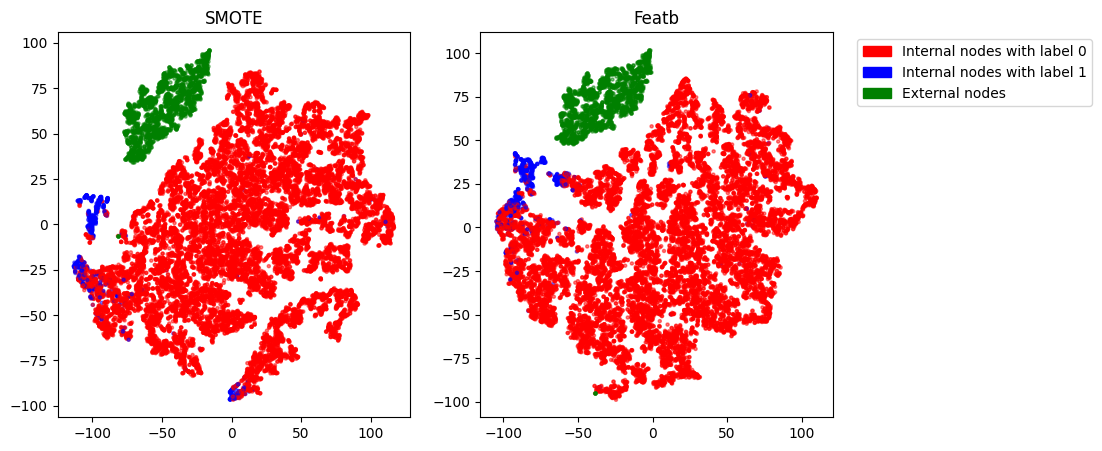

In [75]:
# Plot the embeddings for two models. Mark the internal and external nodes with different colors
# Also mark the internal nodes based on its labels from data['internal'].y
fig,ax = plt.subplots(1,2, figsize=(10,5))
colors = ['r','b']
size = 5
ax[0].scatter(smote_tsne_embeddings[:len(data['internal'].y),0],smote_tsne_embeddings[:len(data['internal'].y),1], c=[colors[int(y)] for y in data['internal'].y],s=size,alpha=0.5)
ax[0].scatter(smote_tsne_embeddings[len(data['internal'].y):,0],smote_tsne_embeddings[len(data['internal'].y):,1], c='g',s=size,alpha=0.5)
ax[0].set_title('SMOTE')
ax[1].scatter(featb_tsne_embeddings[:len(data['internal'].y),0],featb_tsne_embeddings[:len(data['internal'].y),1], c=[colors[int(y)] for y in data['internal'].y],s=size,alpha=0.5)
ax[1].scatter(featb_tsne_embeddings[len(data['internal'].y):,0],featb_tsne_embeddings[len(data['internal'].y):,1], c='g',s=size,alpha=0.5)
ax[1].set_title('Featb')

# Create the legend
import matplotlib.patches as mpatches
internal_patch_0 = mpatches.Patch(color='red', label='Internal nodes with label 0')
internal_patch_1 = mpatches.Patch(color='blue', label='Internal nodes with label 1')
external_patch = mpatches.Patch(color='green', label='External nodes')
# ax[0].legend(handles=[internal_patch_0, internal_patch_1, external_patch])
ax[1].legend(handles=[internal_patch_0, internal_patch_1, external_patch],bbox_to_anchor=(1.05, 1))
plt.show()